# Fastai Midlevel APIs 
> Understanding how Fastai's DataBlock API works behind the scenes harnessing Fa

In [1]:
from fastai2.vision.all import *

import warnings
warnings.filterwarnings('ignore')

## Data Gathering

In [2]:
path = Path('/media/harish3110/AE2461B824618465/datasets/aptos_blindness_detection')
Path.BASE_PATH = path
path.ls()

(#5) [Path('sample_submission.csv'),Path('test.csv'),Path('test_images'),Path('train.csv'),Path('train_images')]

In [3]:
train = pd.read_csv(path/'train.csv')
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
label_dict = {
    0: 'No DR', 
    1: 'Mild', 
    2: 'Moderate', 
    3: 'Severe', 
    4: 'Proliferative DR'
}

## Using DataBlock  API

In [5]:
# presizing
item_tfms=Resize(480),
batch_tfms=aug_transforms(size=224, min_scale=0.75)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('id_code', pref=path/'train_images', suff='.png'),
    get_y=Pipeline([ColReader('diagnosis'), label_dict.__getitem__]), 
    splitter=RandomSplitter(seed=42),
    item_tfms = item_tfms,
    batch_tfms = batch_tfms
)

dls = dblock.dataloaders(train) 

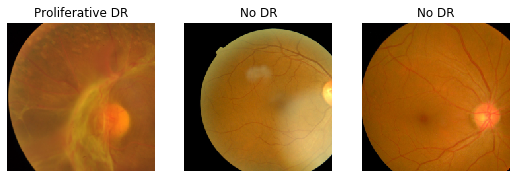

In [6]:
dls.show_batch(max_n=3)

## Using only Transform for the same dataset

In [19]:
class TitledImage(Tuple):
    def show(self, ctx=None, **kwargs): 
        show_titled_image(self, ctx=ctx, **kwargs)

In [20]:
class Tfm(ItemTransform):
    def __init__(self, vocab, o2i, lblr): 
        self.vocab, self.o2i, self.lblr = vocab,o2i,lblr
    def encodes(self, o): 
        return (PILImage.create(ColReader('id_code', pref=path/'train_images', suff='.png')(o)), self.o2i[self.lblr(o)])
    def decodes(self, x): 
        return TitledImage(x[0],self.vocab[x[1]])

In [23]:
labeller = Pipeline([attrgetter('diagnosis'), label_dict.__getitem__])

In [25]:
vals = list(map(label_dict.__getitem__, list(train['diagnosis'].values)))

In [26]:
vocab,o2i = uniqueify(vals, sort=True, bidir=True)
aptos = Tfm(vocab,o2i,labeller)

In [27]:
x,y = aptos(train.iloc[0])
x.shape,y

((2136, 3216), 1)

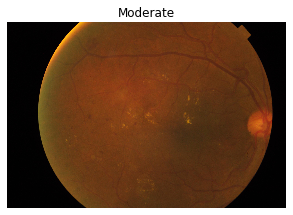

In [28]:
dec = aptos.decode(aptos(train.iloc[0]))
dec.show()

## Setting up the internal state with a setups

We can now make our `ItemTransform` automatically state its state from the data. This way, when we combine together our `Transform` with the data, it will automatically get setup without having to do anything. This is done by adding a `setups` method in the Transform definition

In [44]:
class Tfm(ItemTransform):
    def setups(self, items):
        self.labeller = Pipeline([attrgetter('diagnosis'), label_dict.__getitem__])
        vals = list(map(label_dict.__getitem__, list(train['diagnosis'].values)))
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): 
        print(o)
        return (PILImage.create(ColReader('id_code', pref=path/'train_images', suff='.png')(o)), self.o2i[self.labeller(o)])
    def decodes(self, x): 
        return TitledImage(x[0], self.vocab[x[1]])

In [45]:
aptos = Tfm()
aptos.setup(train)
x,y = aptos(train.iloc[0])
x.shape, y

id_code      000c1434d8d7
diagnosis               2
Name: 0, dtype: object


((2136, 3216), 1)

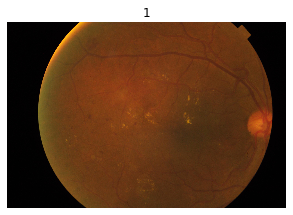

In [46]:
dec = pets.decode((x,y))
dec.show()

## Combining our Transform with data augmentation in a Pipeline

We can also take advantage of fastai's data augmentation transforms if we give the right type to our elements. Instead of returning a standard `PIL.Image`, if our transform returns the fastai type `PILImage`, we can then use any fastai's transform with it. Let's just return a `PILImage` for our first element:

In [48]:
class Tfm(ItemTransform):
    def setups(self, items):
        self.labeller = Pipeline([attrgetter('diagnosis'), label_dict.__getitem__])
        vals = list(map(label_dict.__getitem__, list(train['diagnosis'].values)))
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): 
        print(o)
        return (PILImage.create(ColReader('id_code', pref=path/'train_images', suff='.png')(o)), self.o2i[self.labeller(o)])
    def decodes(self, x): 
        return TitledImage(x[0], self.vocab[x[1]])

We can then combine that transform with ToTensor, Resize or FlipItem to randomly flip our image in a Pipeline:

In [49]:
tfms = Pipeline([Tfm(), Resize(224), FlipItem(p=1), ToTensor()])
tfms

Pipeline: Tfm -> FlipItem -> Resize -> ToTensor

Calling setup on a Pipeline will set each transform in order:

In [50]:
tfms.setup(train)

In [51]:
tfms.vocab

(#5) ['Mild','Moderate','No DR','Proliferative DR','Severe']

In [52]:
x,y = tfms(train.iloc[0])
x.shape,y

id_code      000c1434d8d7
diagnosis               2
Name: 0, dtype: object


(torch.Size([3, 224, 224]), 1)

We can see ToTensor and Resize were applied to the first element of our tuple (which was of type PILImage) but not the second. We can even have a look at our element to check the flip was also applied:

id_code      000c1434d8d7
diagnosis               2
Name: 0, dtype: object


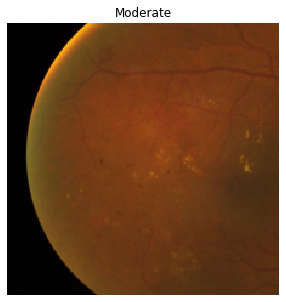

In [53]:
tfms.show(tfms(train.iloc[0]))

## TfmdLists and Datasets

### Using TfmdLists
> One pipeline makes a TfmdLists

Creating a TfmdLists just requires a list of items and a list of transforms that will be combined in a Pipeline:

In [55]:
class Tfm(ItemTransform):
    def setups(self, items):
        self.labeller = Pipeline([ColReader('diagnosis'), label_dict.__getitem__])
        vals = map(self.labeller, items)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): 
        return (PILImage.create(ColReader('id_code', pref=path/'train_images', suff='.png')(o)), self.o2i[self.labeller(o)])
    def decodes(self, x): 
        return TitledImage(x[0],self.vocab[x[1]])

In [56]:
# Used to create separate train and validation transformed lists when creating TfmdLists
splitter = RandomSplitter(seed=42)

In [57]:
splits = splitter(train)
splits

((#2930) [3578,3510,791,2745,707,3395,2294,2868,3118,2426...],
 (#732) [1506,2110,558,1514,3640,3184,1354,3061,2514,276...])

In [58]:
# Presizing to 480
tls = TfmdLists(train, [Resize(480), Tfm(), ToTensor()], splits=splitter(train))

In [59]:
x,y = tls[0]
x.shape,y

(torch.Size([3, 480, 480]), 1)

In [60]:
tls.vocab

(#5) ['Mild','Moderate','No DR','Proliferative DR','Severe']

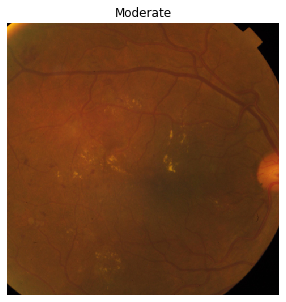

In [61]:
tls.show((x,y))

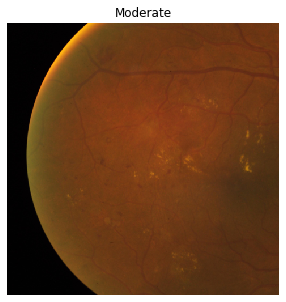

In [62]:
# Another method to show
show_at(tls, 0)

In [109]:
dls = tls.dataloaders(bs=64)

In [110]:
dls.vocab

(#5) ['Mild','Moderate','No DR','Proliferative DR','Severe']

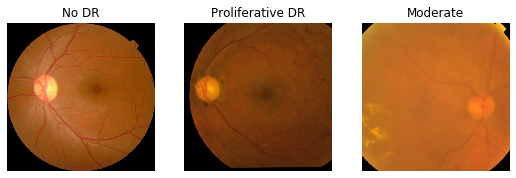

In [111]:
dls.show_batch(max_n=3)

You can even add augmentation transforms, since we have a proper fastai typed image. Just remember to add the `IntToFloatTensor`  transform that deals with the conversion of int to float (augmentation transforms of fastai on the GPU require float tensors). When calling `TfmdLists.dataloaders`, you pass the `batch_tfms` to `after_batch` (and potential new `item_tfms` to `after_item`):

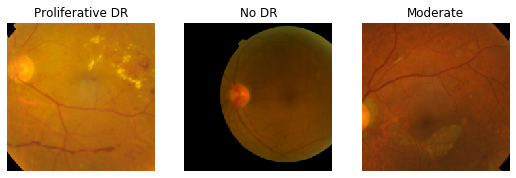

In [112]:
dls = tls.dataloaders(bs=64, after_batch=[IntToFloatTensor(), *aug_transforms(size=224, min_scale=0.75)])
dls.show_batch(max_n=3)

### Using Datasets

Datasets applies a list of list of transforms (or list of Pipelines) lazily to items of a collection, creating one output per list of transforms/Pipeline. This makes it easier for us to separate out steps of a process, so that we can re-use them and modify the process more easily. This is what lays the foundation of the data block API: we can easily mix and match types as inputs or outputs as they are associated to certain pipelines of transforms.

In [69]:
x_tfms = [ColReader('id_code', pref=path/'train_images', suff='.png'), PILImage.create]
y_tfms = [attrgetter('diagnosis'), label_dict.__getitem__,Categorize()]                          

In [70]:
tfms = [x_tfms, y_tfms]

dsets = Datasets(train, tfms, splits=splits)

dls = dsets.dataloaders(bs=64, after_item=[Resize(480), ToTensor(), IntToFloatTensor()])

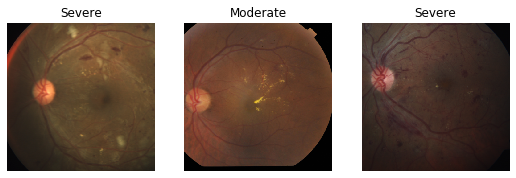

In [71]:
dls.show_batch(max_n=3)

If we just wanted to build one DataLoader from our Datasets (or the previous TfmdLists), you can pass it directly to TfmdDL:

In [72]:
dsets = Datasets(train, tfms)

dl = TfmdDL(dsets, bs=64, after_item=[Resize(480), ToTensor(), IntToFloatTensor()])

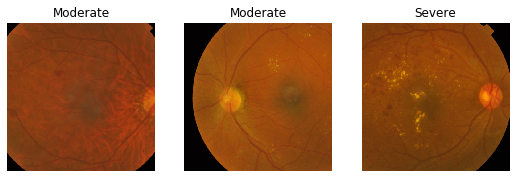

In [73]:
dls.show_batch(max_n=3)

---
---